In [1]:
import pandas as pd
raw=pd.read_csv('tr_eikon_eod_data.csv',index_col=0,parse_dates=True).dropna()
symbol=['SPY','GLD','AAPL.O','MSFT.O']
noa=len(symbol)

In [2]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl,plt
plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000164C5DE7B00>,
      dtype=object)

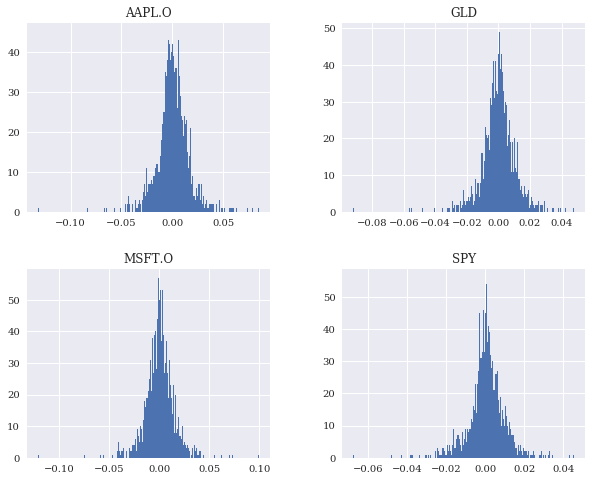

In [3]:
data=raw[symbol]
rets=np.log(data/data.shift(1))
rets.hist(bins=400,figsize=(10,8))

In [4]:
rets.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.002644,-0.000911,0.001727,0.000323
2010-01-06,0.000704,0.016365,-0.016034,-0.006156
2010-01-07,0.004212,-0.006207,-0.001850,-0.010389
2010-01-08,0.003322,0.004951,0.006626,0.006807


In [5]:
rets.mean()*252

SPY       0.102928
GLD       0.009141
AAPL.O    0.212359
MSFT.O    0.136648
dtype: float64

In [6]:
rets.cov()*252

,SPY,GLD,AAPL.O,MSFT.O
SPY,0.021939,0.000062,0.021039,0.022244
GLD,0.000062,0.026209,0.001513,-0.000347
AAPL.O,0.021039,0.001513,0.063773,0.023427
MSFT.O,0.022244,-0.000347,0.023427,0.050917


In [7]:
#Variance * 252
#Std * sqrt(252)

In [8]:
rets.dropna(inplace=True)


In [12]:
rets.head()

,SPY,GLD,AAPL.O,MSFT.O
Date,,,,
2010-01-05,0.002644,-0.000911,0.001727,0.000323
2010-01-06,0.000704,0.016365,-0.016034,-0.006156
2010-01-07,0.004212,-0.006207,-0.001850,-0.010389
2010-01-08,0.003322,0.004951,0.006626,0.006807
2010-01-11,0.001396,0.013202,-0.008861,-0.012802


In [13]:
weights=np.random.rand(noa)

In [14]:
weights

array([0.85353437, 0.32911511, 0.48448774, 0.48618091])

In [15]:
weights/=np.sum(weights)

In [16]:
sum(weights)

1.0

In [17]:
np.sum(rets.mean()*weights)*252

0.1208285955762529

In [18]:
rets.mean().shape

(4,)

In [19]:
weights.shape

(4,)

In [20]:
np.dot(weights.T,np.dot(rets.cov()*252,weights))

0.020085083980014108

In [21]:
def port_ret(weights):
    return np.sum(rets.mean()*weights)*252
def prot_vol(weights):
    return np.sqrt(np.dot(weights.T,np.dot(rets.cov()*252,weights)))

In [22]:
prets=[]
pvols=[]
for p in range(2500):
    weights=np.random.rand(noa)
    weights/=np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(prot_vol(weights))


In [23]:
prets=np.array(prets)
pvols=np.array(pvols)

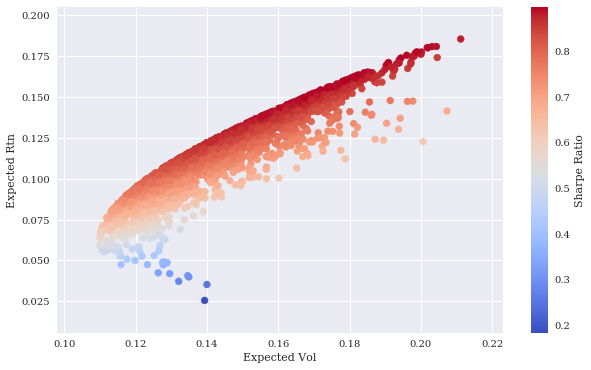

In [24]:
plt.figure(figsize=(10,6))
plt.scatter(pvols,prets,c=prets/pvols,marker='o',cmap='coolwarm')
plt.xlabel("Expected Vol")
plt.ylabel("Expected Rtn")
plt.colorbar(label="Sharpe Ratio")
plt.show()

In [25]:
import scipy.optimize as sco

In [26]:
def min_f(weights):
    return -port_ret(weights)/prot_vol(weights)
cons=({'type':'eq','fun':lambda x: np.sum(x)-1})
bnds=tuple((0,1) for x in range(noa))

In [27]:
eweights=np.array(noa*[1/noa,])

In [28]:
min_f(eweights)

-0.84362033631554

In [29]:
%%time
opts=sco.minimize(min_f,eweights,method='SLSQP',bounds=bnds,constraints=cons)

Wall time: 93.7 ms


In [30]:
opts

     fun: -0.8976673894115292
     jac: array([-2.45958567e-04,  1.92746520e-05,  8.96975398e-05,  8.30292702e-05])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.25454111, 0.04228121, 0.51191357, 0.19126411])

In [31]:
opts['x'].round(3)

array([0.255, 0.042, 0.512, 0.191])

In [32]:
optv=sco.minimize(prot_vol,eweights,method="SLSQP",
                 bounds=bnds,constraints=cons)

In [38]:
optv.fun

0.10942155263386334

In [34]:
optv.x.round(3)

array([0.543, 0.456, 0.   , 0.001])

In [35]:
"why always me?"

'why always me?'

In [36]:
cons=({'type':"eq",'fun':lambda x: port_ret(x)-tret},
     {'type':'eq','fun':lambda x: np.sum(x)-1})

In [37]:
bnds=tuple((0,1) for x in weights)

In [39]:
%%time
trets=np.linspace(0.05,0.2,50)
tvols=[]
for tret in trets:
    res=sco.minimize(prot_vol,eweights,method='SLSQP',
                    bounds=bnds,constraints=cons)
    tvols.append(res.fun)
tvols=np.array(tvols)


Wall time: 2.74 s


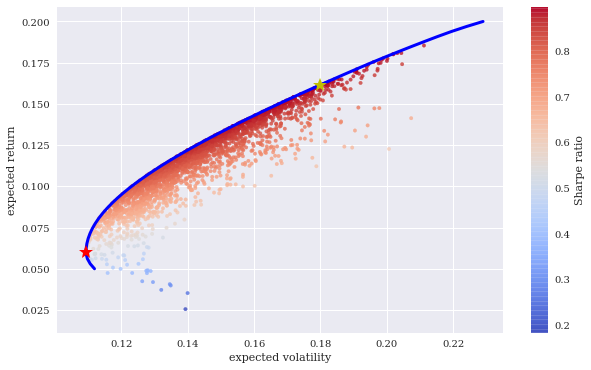

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(pvols,prets,c=prets/pvols,
           marker='.',alpha=.8,cmap='coolwarm')
plt.plot(tvols,trets,'b',lw=3.0)
plt.plot(prot_vol(opts['x']),port_ret(opts['x']),
        'y*',markersize=15)
plt.plot(prot_vol(optv['x']), port_ret(optv['x']),
'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


In [42]:
optv

     fun: 0.10942155263386334
     jac: array([0.10939826, 0.10944918, 0.11098003, 0.10948556])
 message: 'Optimization terminated successfully.'
    nfev: 54
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([5.43263082e-01, 4.55675214e-01, 3.25260652e-19, 1.06170439e-03])

In [43]:
weights

array([0.10854822, 0.23947313, 0.49201582, 0.15996283])

In [44]:
#Captial Market Line

In [45]:
import scipy.interpolate as sci

In [46]:
ind=np.argmin(tvols)
evols=tvols[ind:]
erets=trets[ind:]

In [47]:
tck=sci.splrep(evols,erets)

tuple

In [50]:
#Approximation


In [51]:
f=lambda x: np.sin(x)+0.5*x

In [53]:
def create_plot(x,y,styles,labels,axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label=labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc='best')

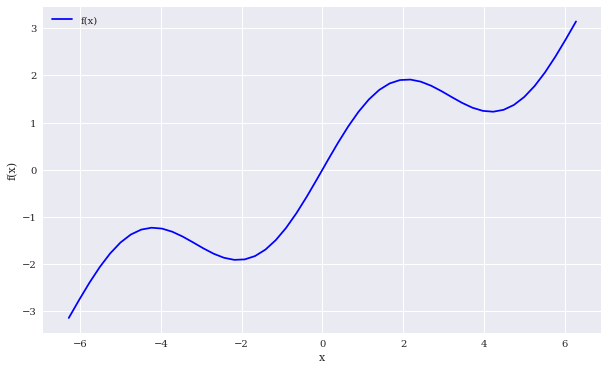

In [54]:
x=np.linspace(-2*np.pi,2*np.pi,50)
create_plot([x], [f(x)], ['b'], ['f(x)'], ['x', 'f(x)'])

In [55]:
res=np.polyfit(x,f(x),deg=1,full=True)

In [56]:
res

(array([ 4.28841952e-01, -1.40254456e-16]),
 array([21.03238686]),
 2,
 array([1., 1.]),
 1.1102230246251565e-14)

In [57]:
ry=np.polyval(res[0],x)

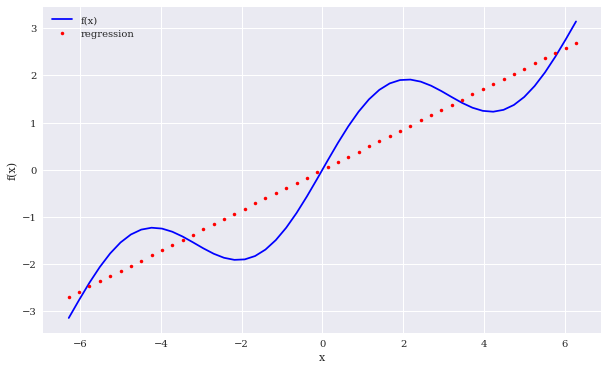

In [58]:
create_plot([x,x],[f(x),ry],['b','r.'],
           ['f(x)','regression'],['x','f(x)'])

In [60]:
reg=np.polyfit(x,f(x),deg=5)
ry=np.polyval(reg,x)

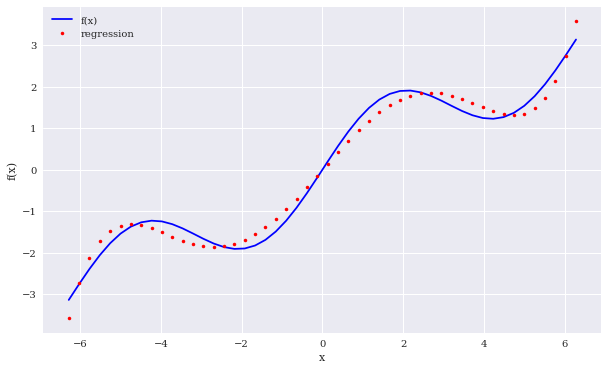

In [61]:
create_plot([x,x],[f(x),ry],['b','r.'],
           ['f(x)','regression'],['x','f(x)'])

In [63]:
reg = np.polyfit(x, f(x), 7)
ry = np.polyval(reg, x)

In [64]:
np.allclose(f(x), ry)

False

In [65]:
np.mean((f(x) - ry) ** 2)

0.0017769134759517593

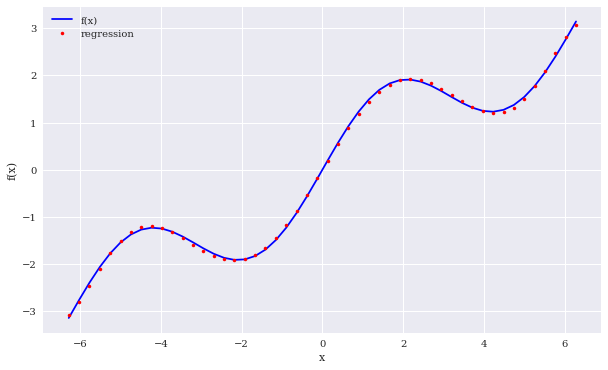

In [66]:
create_plot([x, x], [f(x), ry], ['b', 'r.'],
['f(x)', 'regression'], ['x', 'f(x)'])

In [68]:
matrix=np.zeros((3+1,len(x)))

In [71]:
matrix[3,:]=x**3
matrix[2,:]=x**2
matrix[1,:]=x
matrix[0,:]=1

In [75]:
reg=np.linalg.lstsq(matrix.T,f(x),rcond=None)[0]

In [76]:
ry=np.dot(reg,matrix)

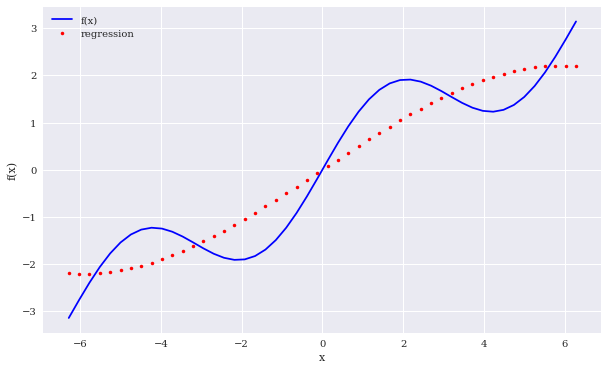

In [77]:
create_plot([x, x], [f(x), ry], ['b', 'r.'],
['f(x)', 'regression'], ['x', 'f(x)'])

In [78]:
reg=np.polyfit(x,f(x),deg=3)
ry=np.polyval(reg,x)

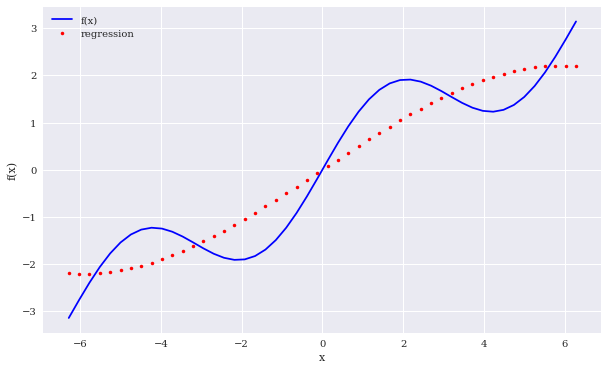

In [79]:
create_plot([x, x], [f(x), ry], ['b', 'r.'],
['f(x)', 'regression'], ['x', 'f(x)'])

In [80]:
matrix[3,:]=np.sin(x)
reg=np.linalg.lstsq(matrix.T,f(x),rcond=None)[0]

In [81]:
ry=np.dot(reg,matrix)

In [82]:
np.allclose(f(x),ry)

True

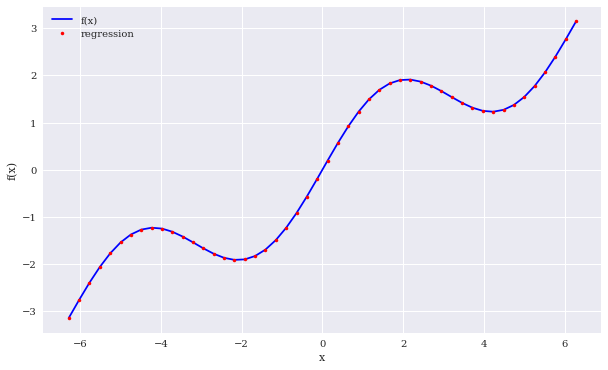

In [83]:
create_plot([x, x], [f(x), ry], ['b', 'r.'],
['f(x)', 'regression'], ['x', 'f(x)'])

In [84]:
xn = np.linspace(-2 * np.pi, 2 * np.pi, 50)


In [85]:
xn = xn + 0.15 * np.random.standard_normal(len(xn))
yn = f(xn) + 0.25 * np.random.standard_normal(len(xn))

In [86]:
reg = np.polyfit(xn, yn, 7)
ry = np.polyval(reg, xn)

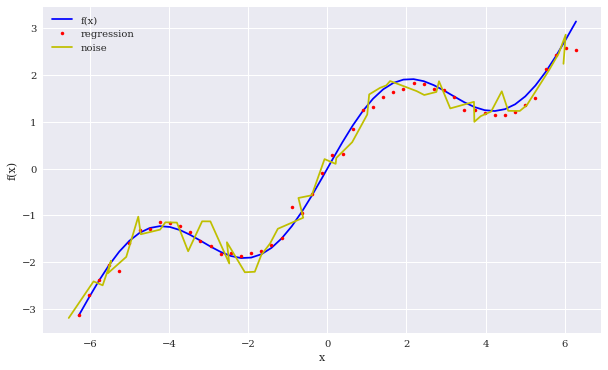

In [87]:
create_plot([x, x,xn], [f(x), ry,yn], ['b', 'r.','y'],
['f(x)', 'regression','noise'], ['x', 'f(x)'])

In [88]:
#In a sense, the regression averages out the noise to
# some extent:

In [89]:
xu = np.random.rand(50) * 4 * np.pi - 2 * np.pi
yu = f(xu)


In [90]:
reg = np.polyfit(xu, yu, 6)
ry = np.polyval(reg, xu)

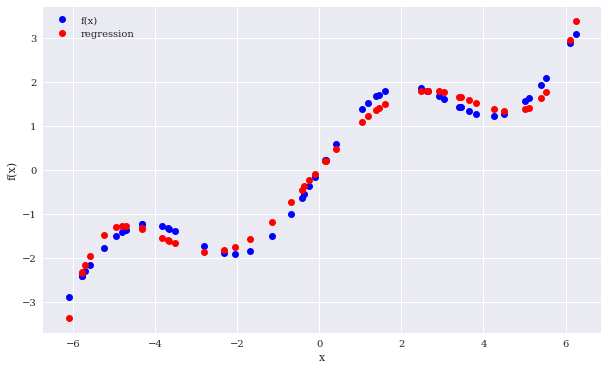

In [93]:
create_plot([xu, xu], [yu, ry], ['bo', 'ro'],
['f(x)', 'regression'], ['x', 'f(x)'])

In [94]:
def fm(p):
    x, y = p
    return np.sin(x) + 0.25 * x + np.sqrt(y) + 0.05 * y ** 2

In [95]:
x = np.linspace(0, 10, 20)
y = np.linspace(0, 10, 20)
X, Y = np.meshgrid(x, y)

In [98]:
x

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [99]:
y

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [100]:
np.meshgrid()

array([[ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
         2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
         5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
         7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ],
       [ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
         2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
         5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
         7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ],
       [ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
         2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
         5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
         7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ],
       [ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
         2.63157895,  3.15789474,  3.68421053,  

![meshgrid](https://i.stack.imgur.com/8Mbig.png)

In [106]:
Z=fm((X,Y))

In [108]:
from mpl_toolkits.mplot3d import Axes3D

No handles with labels found to put in legend.


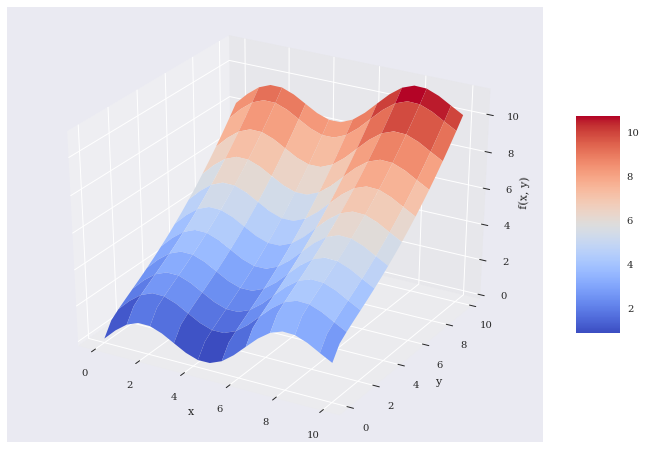

In [123]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
cmap='coolwarm', linewidth=0.5,
antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.legend()
fig.colorbar(surf, shrink=0.5, aspect=5)

In [118]:
x,y=X.flatten(),Y.flatten()
matrix = np.zeros((len(x), 6 + 1))
matrix[:, 6] = np.sqrt(y)
matrix[:, 5] = np.sin(x)
matrix[:, 4] = y ** 2
matrix[:, 3] = x ** 2
matrix[:, 2] = y
matrix[:, 1] = x
matrix[:, 0] = 1

In [119]:
reg = np.linalg.lstsq(matrix, fm((x, y)), rcond=None)[0]

In [120]:
RZ = np.dot(matrix, reg).reshape((20, 20))

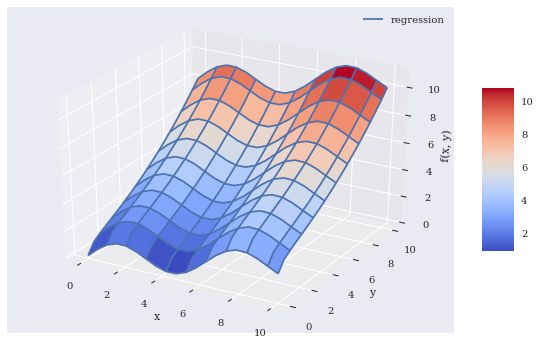

In [124]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
cmap='coolwarm', linewidth=0.5,
antialiased=True)
surf2 = ax.plot_wireframe(X, Y, RZ, rstride=2, cstride=2,label='regression')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.legend()
fig.colorbar(surf, shrink=0.5, aspect=5)
